In [1]:
from __future__ import division
from pynq import Overlay
from pynq import GPIO
import time
from pynq import Xlnk
import numpy as np

overlay = Overlay('/home/xilinx/pynq/overlays/softmax/design_1.bit')
#overlay?

![title](softmax/gpio.png)

In [2]:
rst = GPIO(GPIO.get_gpio_pin(0), 'out')
triggle = GPIO(GPIO.get_gpio_pin(1), 'out')

bool_16 = 1

triggle.write(1)
rst.write(1)
rst.write(0)
time.sleep(1)
rst.write(1)

num = 4096

![title](softmax/axi_m.png)

In [3]:
xlnk = Xlnk()
buf = xlnk.cma_array(shape=(num,), dtype=np.uint32, cacheable=0)
addr = buf.physical_address

myip = overlay.axi_s_control_0
myip.write(0x00,addr)
myip.write(0x04,addr)
myip.write(0x08,num)
myip.write(0x0c,bool_16)

myip.read(0x08)

4096

![title](softmax/fix.png)

In [4]:
import matplotlib.pyplot as plt
def float2fix16():
    data_arr = []
    original_f = open("/home/xilinx/pynq/overlays/softmax/input_5.txt",'r')

    # for x in original_f:
    #     print(x,end="")

    for _ in original_f:
        data_arr.append(float(_.strip()))
    data_arr = np.array(data_arr)
    dara_arr_init = data_arr
    for i in range(10):
        print(dara_arr_init[i])
    print("------------------")
    # print(data_arr)

    num_max = data_arr.max()
    data_arr = data_arr - num_max
    data_arr = abs(data_arr)
    # print(data_arr)

    fix_array = []
    for _ in data_arr:
        dot_pos = 0
        zs = int(_)
        xs = _ - zs
        while(zs != 0):
            dot_pos += 1
            zs = zs >> 1
        # print(dot_pos)
        _ = int(_ * 2**(13-dot_pos))
        fix = (dot_pos << 13) + _
        # print(fix)
        # print(hex(fix))
        fix_array.append(fix)
    return fix_array,dara_arr_init

original_arr,float_arr = float2fix16()
for i in range(len(buf)):
    buf[i] = original_arr[i]
for i in range(10):
    print(hex(buf[i]))

4.51346542727
-0.575274318749
0.847524503865
1.36382970336
1.97547231451
1.43599437104
-4.98817709218
2.88877261067
1.72245818548
-0.946137884747
------------------
0xf91
0x764d
0x709c
0x5d16
0x5832
0x5c82
0x93f9
0x50e3
0x5a38
0x77c8


In [5]:
triggle.write(1)
time.sleep(1)
triggle.write(0)
time.sleep(1)
for i in range(10):
    print(hex(buf[i]))

0x6551
0x9e
0x297
0x457
0x800
0x4aa
0x1
0x13f5
0x636
0x6d


In [6]:
fpga_arr = []
for i in range(len(buf)):
    fpga_arr.append(buf[i])
# fpga_arr

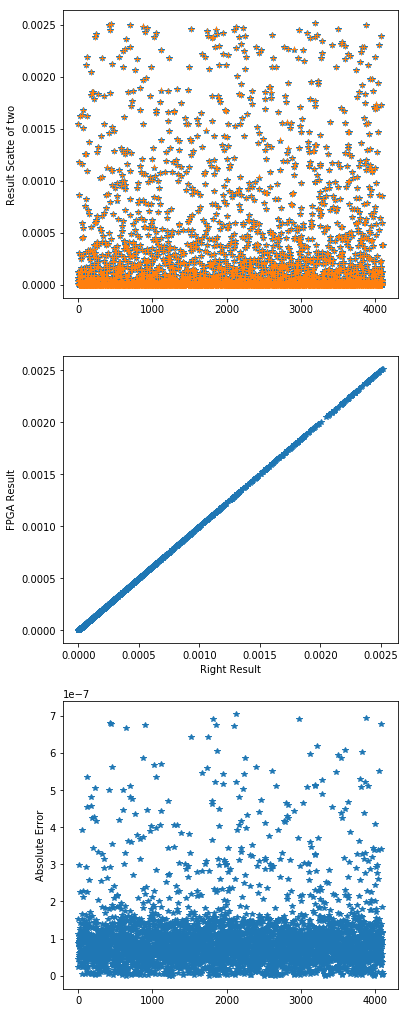

In [7]:
def draw_error(float_arr, arr_fpga, bool_16):
	if(bool_16 == 1):
		chufa = 24
	else:
		chufa = 16
	# for _ in fin:
	# 	x.append(float(_))
	# for _ in fout:
	# 	y.append(int(_,16)/(2**(chufa)))   #  从32 修改为 24  适应-5~5  || 从24改为20   适应-10~10
	x = np.array(float_arr)
	x = np.exp(x)
	x = x/np.sum(x)
	# print x
	y = np.array(arr_fpga)/(2**chufa)
	# print y
	error = abs(x - y)
	cnt  = 0
	for _ in error:
		if _ > 0.00000001:
			cnt += 1
	# print cnt
	plt.figure(figsize=(6,18))
	plt.subplot(311)
	plt.ylabel('Result Scatte of two')
	plt.plot(x,"*")
	plt.plot(y,"+")
	plt.subplot(312)
	plt.xlabel('Right Result')
	plt.ylabel('FPGA Result')
	plt.plot(x,y,"*")
	plt.subplot(313)
	plt.ylabel('Absolute Error')
	plt.plot(error,"*")

    
draw_error(float_arr, fpga_arr, bool_16)